# Module 5: Classification

* So far, we have focused on _regression_ tasks where the objective is to predict a scalar continuous value, given some inputs
* In many tasks however, the output is neither continuous nor ordered, e.g., predict whether an image is a cat, dog, or lion. 
* Such tasks are called _classification_ tasks because the objective is to classify the input into one of $N$ classes

# Simple Binary Classification Example Which Can be Solved with Linear Classifier

# Complicated Example which Cannot be Solved with Linear Classifier

# Training a Neural Network Classifier: Cross-Entropy Loss

# Implementing the Classifier


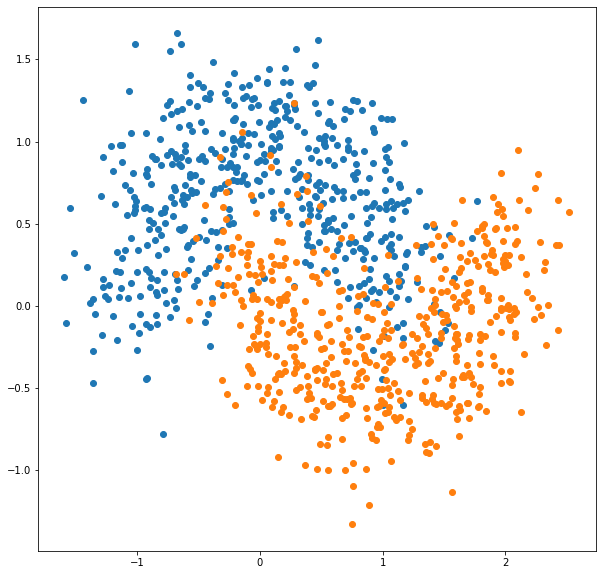